#### Classification | Model

# Predicting Heart Disease  

### Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
   [Data Summary](#31)<br/>
   [Classification Viability](#32)<br/>
   [Classification Metrics](#33)<br/>
4. [Baselining](#4)<br/>
5. [Validation](#5)<br/>
6. [Model Iterations](#6) <br/>
    1 [Dummy Classifier](#61)<br/>
    2 [Logistic Regression](#62)<br/>
    3 [Decision Trees: Depth 2](#63)<br/>
    4 [Decision Trees: Depth 4](#64)<br/>
    5 [Random Forests](#65)<br/>
    6 [Gradient Boosted Trees: xgboost](#66)<br/>
    7 [Naive Bayes: Bernoulli](#67)<br/>
    8 [Naive Bayes: Gaussian](#68)<br/>
    9 [Naive Bayes: Multinomial](#69)<br/>
    10 [Ensemble:  Naive Bayes Hard Voting Classifier](#610)<br/>
    11 [Ensemble:  Naive Bayes Soft Voting Classifier](#611)<br/>
    12 [Ensemble:  Stacking Classifier (non-NBs)](#612)<br/>
    [Feature Engineering](#fe)<br/>
    13 [Logistic regression: Question groups](#613)<br/>
    14 [Logistic regression: Risk factors](#614)<br/>
    15 [Logistic regression: Question groups + Risk factor features](#615)<br/>
    [Class Imbalance Handling](#cih)<br/>
    [Best Performing Model](#bpm)<br/>
    [Model Tuning: GridSearchCV](#gscv)<br/>
    16 [Logistic regression: GridSearchCV](#616)<br/>
7. [Model Selection ](#7)<br/>



In [1]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import dataframe_image as dfi
import pickle
import warnings
warnings.filterwarnings("ignore")
# import plotly.express as px
# import plotly.graph_objects as go
                        
plt.style.use('ggplot')
%matplotlib inline
sns.set_style("whitegrid")

np.set_printoptions(suppress=True)

from mlxtend.classifier import StackingClassifier
from plotly.subplots import make_subplots           
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# 1 | Research Design<a id='1'></a> 

* **Reserach Question:** How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

# 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [2]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') 


In [3]:
# clean df
heart_disease_df.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,Yes,No,5.0,Yes,55-59,Female,White,Yes,Yes,No,Yes,No,16.60,Very good,30.0,No,3.0,No
1,Yes,No,7.0,No,80 or older,Female,White,No,No,No,No,Yes,20.34,Very good,0.0,No,0.0,No
2,Yes,No,8.0,Yes,65-69,Male,White,Yes,Yes,No,No,No,26.58,Fair,30.0,No,20.0,No


In [4]:
# transformed df: mapped categorical variables to numerical values 
heart_disease_df_map.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


[back to top](#top)

# 3 | Exporatory Data Analysis<a id='3'></a> 

#### Using `heart_disease_df_map` with mapped variables for modeling.
##### Note: Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).

### 3.1 Data Summary<a id='31'></a> 

In [5]:
# dataframe info
heart_disease_df_map.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

#### No missing data, all data types are numerical.

[back to top](#top)

### 3.2 Classification Viability<a id='32'></a> 

In [6]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


,count,mean,std,min,25%,50%,75%,max
behavior_activity,319795.000000,0.775362,0.417344,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol,319795.000000,0.068097,0.251912,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
behavior_tobacco,319795.000000,0.412477,0.492281,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age,319795.000000,52.440945,18.069747,18.000000,40.000000,55.000000,65.000000,80.000000
demg_gender,319795.000000,1.475273,0.499389,1.000000,1.000000,1.000000,2.000000,2.000000
demg_race,319795.000000,5.396742,1.212208,1.000000,6.000000,6.000000,6.000000,6.000000
disease_asthma,319795.000000,0.134061,0.340718,0.000000,0.000000,0.000000,0.000000,1.000000
disease_diabetes,319795.000000,0.207205,0.554528,0.000000,0.000000,0.000000,0.000000,3.000000
disease_kidney,319795.000000,0.036833,0.188352,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197


#### A classification model is viable.

[back to top](#top)

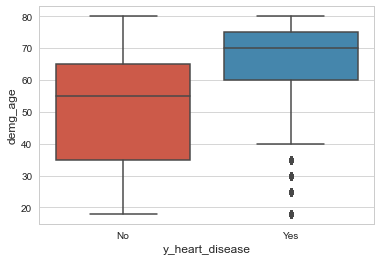

In [8]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


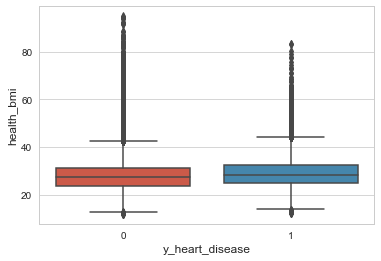

In [9]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


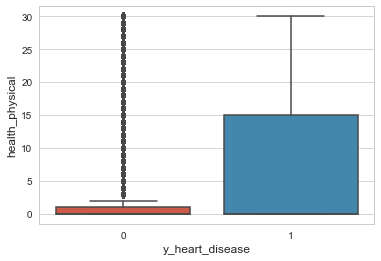

In [10]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [11]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


Positives/Negatives Ratio: 9.36 %
No     292422
Yes     27373
Name: y_heart_disease, dtype: int64


[back to top](#top)

### 3.3 Classification Metrics<a id='33'></a> 

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients. 

[back to top](#top)

# 4 | Baseline<a id='4'></a> 

#### Logistic regression with three features based on correlation matrix.

In [12]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 
X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                                                        y_base,
                                                                        test_size=0.2,
                                                                        random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base, 
                                                                                y_train_base, 
                                                                                test_size = .25, 
                                                                                random_state = 42)

# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)


In [13]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = log_reg_base.predict(X_val_scaled_base) 

In [14]:
# score on recall and roc auc
zero = ["Baseline logistic regression", 'log_reg_base',
        recall_score(y_pred_base, y_val_base),
        roc_auc_score(y_val_base, log_reg_base.predict_proba(X_val_scaled_base)[:,1])]
zero

['Baseline logistic regression', 'log_reg_base', 0.36, 0.7858257042010828]

[back to top](#top)

# 5 | Validation<a id='5'></a>

#### Validation and testing scheme to use in [model selection](#7). 

In [15]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 
X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size = .25, 
                                                            random_state = 42)

# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


[back to top](#top)

# 6 | Model Iterations <a id='6'></a> 

### 6.1 Dummy Classifier<a id='61'></a> 

In [16]:
clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_val)


In [17]:
one = ["Dummy classifier", 'clf',
         recall_score(y_pred_clf, y_val), 
         roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])]
one

['Dummy classifier', 'clf', 0.0, 0.5]

#### Dummy classifier performed worse than [baseline](#4).<br/>

[back to top](#top)

### 6.2 Logistic Regression<a id='62'></a> 

In [18]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled) 


In [19]:
two = ["Logistic regression", 'log_reg',
       recall_score(y_pred_log_reg, y_val), 
       roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
two

['Logistic regression', 'log_reg', 0.5195052331113226, 0.8411422086561615]

#### Logistic regression (with all features) performed better than [baseline](#4).<br/>

[back to top](#top)

### 6.3 Decision Trees: Depth 2<a id='63'></a> 

In [20]:
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred_dt_2 = dt_2.predict(X_val)


In [25]:
three = ["Decision tree (depth=2)", 'dt_2', 
       recall_score(y_pred_dt_2, y_val), 
       roc_auc_score(y_val, dt_2.predict_proba(X_val)[:,1])]
three

['Decision tree (depth=2)', 'dt_2', 0.0, 0.7653574312653932]

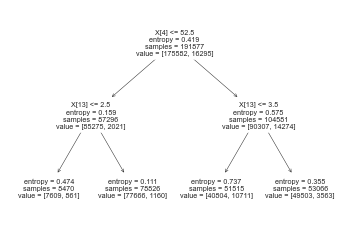

In [26]:
tree.plot_tree(dt_2);

### 6.4 Decision Trees: Depth 4<a id='64'></a> 

In [27]:
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred_dt_4 = dt_4.predict(X_val)


In [28]:
four = ["Decision tree (depth=4)", 'dt_4',
         recall_score(y_pred_dt_4, y_val),
         roc_auc_score(y_val, dt_4.predict_proba(X_val)[:,1])]
four

['Decision tree (depth=4)', 'dt_4', 0.0, 0.8112940974985579]

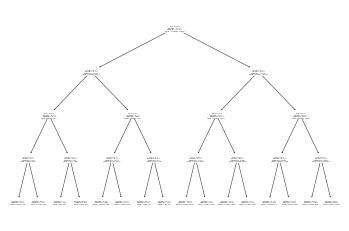

In [29]:
tree.plot_tree(dt_4);

#### Decsion trees performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.5 Random Forests <a id='65'></a> 

In [30]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_forest = forest.predict(X_val)


In [31]:
five = ["Random forest", 'forest',
        recall_score(y_pred_forest, y_val),
        roc_auc_score(y_val, forest.predict_proba(X_val)[:,1])]
five

['Random forest', 'forest', 0.3641552511415525, 0.7959730724780141]

#### Random forest performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.6 Gradient Boosted Trees: xgboost<a id='66'></a> 

In [32]:
# XGBoost

gbm = xgb.XGBRegressor( 
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )

eval_set=[(X_train, y_train),(X_val,y_val)] 

gbm_fit = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
#                     eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True 
                   )

[0]	validation_0-auc:0.79108	validation_1-auc:0.79024
[1]	validation_0-auc:0.80688	validation_1-auc:0.80559
[2]	validation_0-auc:0.81821	validation_1-auc:0.81637
[3]	validation_0-auc:0.81953	validation_1-auc:0.82055
[4]	validation_0-auc:0.82335	validation_1-auc:0.82405
[5]	validation_0-auc:0.82174	validation_1-auc:0.82318
[6]	validation_0-auc:0.82506	validation_1-auc:0.82588
[7]	validation_0-auc:0.82664	validation_1-auc:0.82673
[8]	validation_0-auc:0.82789	validation_1-auc:0.82793
[9]	validation_0-auc:0.82791	validation_1-auc:0.82748
[10]	validation_0-auc:0.82808	validation_1-auc:0.82850
[11]	validation_0-auc:0.82813	validation_1-auc:0.82799
[12]	validation_0-auc:0.82846	validation_1-auc:0.82820
[13]	validation_0-auc:0.82927	validation_1-auc:0.82856
[14]	validation_0-auc:0.82918	validation_1-auc:0.82809
[15]	validation_0-auc:0.83040	validation_1-auc:0.82932
[16]	validation_0-auc:0.83116	validation_1-auc:0.83017
[17]	validation_0-auc:0.83138	validation_1-auc:0.83071
[18]	validation_0-au

[149]	validation_0-auc:0.84723	validation_1-auc:0.84445
[150]	validation_0-auc:0.84725	validation_1-auc:0.84445
[151]	validation_0-auc:0.84726	validation_1-auc:0.84445
[152]	validation_0-auc:0.84727	validation_1-auc:0.84444
[153]	validation_0-auc:0.84730	validation_1-auc:0.84447
[154]	validation_0-auc:0.84732	validation_1-auc:0.84446
[155]	validation_0-auc:0.84734	validation_1-auc:0.84447
[156]	validation_0-auc:0.84737	validation_1-auc:0.84446
[157]	validation_0-auc:0.84740	validation_1-auc:0.84448
[158]	validation_0-auc:0.84741	validation_1-auc:0.84447
[159]	validation_0-auc:0.84743	validation_1-auc:0.84447
[160]	validation_0-auc:0.84747	validation_1-auc:0.84447
[161]	validation_0-auc:0.84747	validation_1-auc:0.84447
[162]	validation_0-auc:0.84748	validation_1-auc:0.84447
[163]	validation_0-auc:0.84750	validation_1-auc:0.84447
[164]	validation_0-auc:0.84752	validation_1-auc:0.84446
[165]	validation_0-auc:0.84754	validation_1-auc:0.84447
[166]	validation_0-auc:0.84755	validation_1-auc:

#### [220]	validation_0-auc: 0.84848	validation_1-auc: 0.84449


In [33]:
y_pred_gbm = gbm.predict(X_val)
y_pred_gbm

array([0.00727439, 0.02875089, 0.1310833 , ..., 0.00484608, 0.12610735,
       0.00575493], dtype=float32)

In [34]:
six = ["XGBoost", 'gbm',
        recall_score(y_val, np.round(gbm.predict(X_val))), 
        roc_auc_score(y_val, np.round(gbm.predict(X_val)))]
six


['XGBoost', 'gbm', 0.08494349252643091, 0.5390770170719649]

#### XGBoost performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.7. Naive Bayes: Bernoulli<a id='67'></a> 

In [35]:
# BernoulliNB() 
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val) 


In [36]:
seven = ["Bernoulli NB", 'bern',
       recall_score(y_predict_bern, y_val),
       roc_auc_score(y_val, bern.predict_proba(X_val)[:,1])]

five

['Random forest', 'forest', 0.3641552511415525, 0.7959730724780141]

### 6.8. Naive Bayes: Gaussian<a id='68'></a> 

In [37]:
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)


In [38]:
eight = ["Gaussian NB",'gaus',
         recall_score(y_pred_gaus, y_val),
         roc_auc_score(y_val, gaus.predict_proba(X_val)[:,1])]
eight

['Gaussian NB', 'gaus', 0.26453726453726456, 0.8053429818657589]

### 6.9. Naive Bayes: Multinomial<a id='69'></a> 

In [39]:
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)


In [40]:
nine = ["Multinomial NB", 'multi',
        recall_score(y_pred_multi, y_val),
        roc_auc_score(y_val, multi.predict_proba(X_val)[:,1])]
nine

['Multinomial NB', 'multi', 0.21883163144146284, 0.7628424887440532]

#### Naive Bayes performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.10 Ensemble: Naive Bayes Hard Voting Classifier <a id='610'></a> 

In [41]:
# set up voting classifier ensemble

nb_names = ['bern', 'gaus', 'multi']
nb_vars = [eval(n) for n in nb_names]

nb_list = list(zip(nb_names, nb_vars))
nb_list


[('bern', BernoulliNB()), ('gaus', GaussianNB()), ('multi', MultinomialNB())]

In [42]:
vote_hard = VotingClassifier(estimators= nb_list,
                             voting='hard',
                             n_jobs=-1)
vote_hard.fit(X_train, y_train)
y_pred_hard = vote_hard.predict(X_val)


In [46]:
ten = ["Hard NB Voting Classifier", 'vote_hard',
       recall_score(y_pred_hard, y_val),
       roc_auc_score(y_val, vote_hard.predict(X_val))]
ten

['Hard NB Voting Classifier',
 'vote_hard',
 0.29335192933519294,
 0.6335377211124092]

### 6.11 Ensemble: Naive Bayes Soft Voting Classifier <a id='611'></a> 

In [47]:
vote_soft = VotingClassifier(estimators= nb_list,
                             voting='soft',
                             n_jobs=-1)

vote_soft.fit(X_train, y_train)
y_pred_soft = vote_soft.predict(X_val)


In [48]:
eleven = ["Soft NB Voting Classifier", 'vote_soft',
       recall_score(y_pred_soft, y_val), 
       roc_auc_score(y_val, vote_soft.predict_proba(X_val)[:,1])]
eleven

['Soft NB Voting Classifier',
 'vote_soft',
 0.28701127544296384,
 0.7759019684959619]

#### Voting classifer ensemble of Naive Bayes performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.12 Ensemble:  Stacking Classifier (non-NBs) <a id='612'></a> 

In [59]:
model_names = ['clf', 'log_reg', 'dt_2', 'dt_4', 'forest', 'gbm']

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))
model_list

[('clf', DummyClassifier(strategy='most_frequent')),
 ('log_reg', LogisticRegression()),
 ('dt_2', DecisionTreeClassifier(criterion='entropy', max_depth=2)),
 ('dt_4', DecisionTreeClassifier(criterion='entropy', max_depth=4)),
 ('forest', RandomForestClassifier()),
 ('gbm',
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=30000,
               n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
               predictor='auto', random_state=0, reg_alpha=0, ...))]

In [67]:
stacked = StackingClassifier(classifiers= model_list, 
                             meta_classifier=LogisticRegression(),
                             use_probas=False) 

In [72]:
# stacked.fit(X_train, y_train)
# y_pred_stack = stacked.predict(X_val)


In [74]:
# tweleve = ["Stacked", 'stacked',
#           recall_score(y_pred_stack, y_val),
#           roc_auc_score(y_val, stacked.predict_proba(X_val)[:,1])]
# tweleve

#### Stacking ensemble (excluding Naive Bayes) performed worse than [logistic regression](#62). 


[back to top](#top)

## Feature Engineering <a id='fe'></a> 

### Features: Question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [75]:
# 1 behaviors = phyiscial activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures'],
      dtype='object')

### Features: Risk factors
Heart disease risk factors by [CDC](https://www.cdc.gov/heartdisease/facts.htm). 

In [76]:
# risk factors = diabetes + bmi + physical activity + alcohol
heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +  
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures', 'risk_factors'],
      dtype='object')

### 6.13 Logistic regression: question groups<a id='613'></a> 

In [77]:
# separate target from question groups features: y/X_grp
y_grp = heart_disease_df_map['y_heart_disease'] 
X_grp = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'measures']]

# split data test/train/validate
X_train_grp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp, 
                                                    y_grp, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp, 
                                                                    y_train_grp, 
                                                                    test_size = .25, 
                                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)


In [78]:
# LR question groups features
log_reg_grp = LogisticRegression()
log_reg_grp.fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled) 


In [79]:
thirteen = ["Logistic regression group features", 'log_reg_grp',
           recall_score(y_pred_grp, y_val_grp), 
           roc_auc_score(y_val_grp, log_reg_grp.predict_proba(X_val_grp_scaled)[:,1])]
thirteen

['Logistic regression group features',
 'log_reg_grp',
 0.38953488372093026,
 0.7971619825669125]

[back to top](#top)

### 6.14 Logistic regression: risk factors<a id='614'></a> 

In [80]:
# separate target from engineered features: y/X_risk
y_risk = heart_disease_df_map['y_heart_disease'] 
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                    'health_bmi',
                                    'behavior_activity', 
                                   'behavior_alcohol']]

# split data test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, 
                                                    y_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk, 
                                                                        y_train_risk, 
                                                                        test_size = .25, 
                                                                        random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)


In [81]:
# LR risk factor features
log_reg_risk = LogisticRegression()
log_reg_risk.fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled) 


In [97]:
fourteen = ["Logistic regression risk factor features", 'log_reg_risk',
            recall_score(y_pred_risk, y_val_risk), 
            roc_auc_score(y_val_risk, log_reg_risk.predict_proba(X_val_risk_scaled)[:,1])]


[back to top](#top)

### 6.15 Logistic regression: question groups + risk factor features<a id='615'></a> 

In [83]:
# separate target from question groups + risk factor features: y/X_grp_risk
y_grp_risk = heart_disease_df_map['y_heart_disease'] 
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'measures',
    'behavior_activity',
    'behavior_alcohol',
    'disease_diabetes',
    'health_bmi'
    ]]

# split data test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk, 
                                                    y_grp_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk, 
                                                                            y_train_grp_risk, 
                                                                            test_size = .25, 
                                                                            random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)


In [84]:
# LR question groups + risk factor features
log_reg_grp_risk = LogisticRegression()
log_reg_grp_risk.fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled) 


In [85]:
fifteen = ["Logistic regression question groups + risk factor features", 'log_reg_grp_risk',
            recall_score(y_pred_grp_risk, y_val_grp_risk), 
            roc_auc_score(y_val_grp_risk, log_reg_grp_risk.predict_proba(X_val_grp_risk_scaled)[:,1])]


#### Models with feature engineering performed worse than [logistic regression](#62). 

[back to top](#top)

## Class Imblance Handling <a id='cih'></a> 

In [86]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

In [87]:
# class_weight adjustments
# _sklearn fbeta score – f2 or f3 to upweight recall_

In [88]:
# decision threshold to max recall

In [90]:
# # precision and recall curves
# y_pred = log_reg_gridcv.predict(X_test_scaled) 

# precision_curve, recall_curve, threshold_curve = precision_recall_curve(
#     y_test, log_reg_gridcv.predict_proba(X_test)[:,1] )

# f, ax = plt.subplots(figsize=(10, 6))
# plt.plot(threshold_curve, precision_curve[1:],label='precision')
# plt.plot(threshold_curve, recall_curve[1:], label='recall')
# plt.legend(loc='center')
# plt.xlabel('Threshold');
# plt.title('Precision and Recall Curves')
# plt.savefig("precision-recall-curves.jpeg");

#### Models with class imbalance handling performed ??? than [logistic regression](#62). 

[back to top](#top)

## Best Performing Model <a id='bpm'></a> 

In [98]:
# df to summarize model performance

models = zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, thriteen, fourteen, fifteen
# tweleve
model_eval = pd.DataFrame(data = models, columns = ['Model', 
                                                    'Variable', 
                                                    'Recall', 
                                                    'ROC AUC'])
model_eval

,Model,Variable,Recall,ROC AUC
0,Baseline logistic regression,log_reg_base,0.360000,0.785826
1,Dummy classifier,clf,0.000000,0.500000
2,Logistic regression,log_reg,0.519505,0.841142
3,Decision tree (depth=2),dt_2,0.000000,0.765357
4,Decision tree (depth=4),dt_4,0.000000,0.811294
5,Random forest,forest,0.364155,0.795973
6,XGBoost,gbm,0.084943,0.539077
7,Bernoulli NB,bern,0.365447,0.762406
8,Gaussian NB,gaus,0.264537,0.805343
9,Multinomial NB,multi,0.218832,0.762842


In [99]:
# Q. Which model scored best on recall? 
model_eval.sort_values(by='Recall', ascending=False).head(5)
# A. Logistic regression

,Model,Variable,Recall,ROC AUC
2,Logistic regression,log_reg,0.519505,0.841142
14,Logistic regression question groups + risk fac...,log_reg_grp_risk,0.466844,0.799779
7,Bernoulli NB,bern,0.365447,0.762406
5,Random forest,forest,0.364155,0.795973
0,Baseline logistic regression,log_reg_base,0.360000,0.785826


In [100]:
# Q. Which model scored best on ROC AUC? 
model_eval.sort_values(by='ROC AUC', ascending=False).head(5)
# A. Logistic regression

,Model,Variable,Recall,ROC AUC
2,Logistic regression,log_reg,0.519505,0.841142
4,Decision tree (depth=4),dt_4,0.000000,0.811294
8,Gaussian NB,gaus,0.264537,0.805343
14,Logistic regression question groups + risk fac...,log_reg_grp_risk,0.466844,0.799779
5,Random forest,forest,0.364155,0.795973


#### [Logistic regression](#62) performs best on recall and ROC AUC. 

[back to top](#top)

## Model Tuning: GridSearchCV <a id='gscv'></a> 

In [101]:
# find best C params and penalty type

grid={"C": np.logspace(-3,3,7), "penalty":["l1","l2"]}# L1 lasso, L2 ridge
logreg = LogisticRegression()
logregcv = GridSearchCV(logreg, grid, cv=10)
logregcv.fit(X_train,y_train)

print("Tuned Hpyerparameters :(best parameters) ", logregcv.best_params_)
print("Accuracy :", logregcv.best_score_)

KeyboardInterrupt: 

### 6.16 Logistic regression: GridSearchCV<a id='616'></a> 

In [102]:
log_reg_gridcv = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv.fit(X_train_scaled, y_train)
y_pred_log_reg_gridcv = log_reg_gridcv.predict(X_val_scaled) 


In [103]:
sixteen = ['Logistic regression GridSearchCV', 'log_reg_gridcv',
             recall_score(y_pred_log_reg_gridcv, y_val),
             roc_auc_score(y_val, log_reg_gridcv.predict_proba(X_val_scaled)[:,1])]
sixteen

['Logistic regression GridSearchCV',
 'log_reg_gridcv',
 0.5222437137330754,
 0.8412275311651765]

In [104]:
# add tuned model to model_eval df
sixteen = {
    'Model': 'Logistic regression GridSearchCV', 
    'Variable': 'log_reg_gridcv', 
    'Recall': recall_score(y_pred_log_reg_gridcv, y_val) ,
    'ROC AUC': roc_auc_score(y_val, log_reg_gridcv.predict_proba(X_val_scaled)[:,1])
}
model_eval = model_eval.append(sixteen, ignore_index = True)
  
display(model_eval)

,Model,Variable,Recall,ROC AUC
0,Baseline logistic regression,log_reg_base,0.360000,0.785826
1,Dummy classifier,clf,0.000000,0.500000
2,Logistic regression,log_reg,0.519505,0.841142
3,Decision tree (depth=2),dt_2,0.000000,0.765357
4,Decision tree (depth=4),dt_4,0.000000,0.811294
5,Random forest,forest,0.364155,0.795973
6,XGBoost,gbm,0.084943,0.539077
7,Bernoulli NB,bern,0.365447,0.762406
8,Gaussian NB,gaus,0.264537,0.805343
9,Multinomial NB,multi,0.218832,0.762842


[back to top](#top)

# 7 | Model Selection<a id='7'></a> 

#### Model winner: `log_reg_gridcv`

### 7.1 Finalize and test<a id='71'></a> 

In [ ]:
# retrain this model on all training + validation data. 
# make predictions on the test data and score these predictions, 
# reporting this score as your estimate of the model's generalization performance.



In [109]:
log_reg_gridcv = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv.fit(X_test_scaled, y_test)
y_pred = log_reg_gridcv.predict(X_test_scaled) 


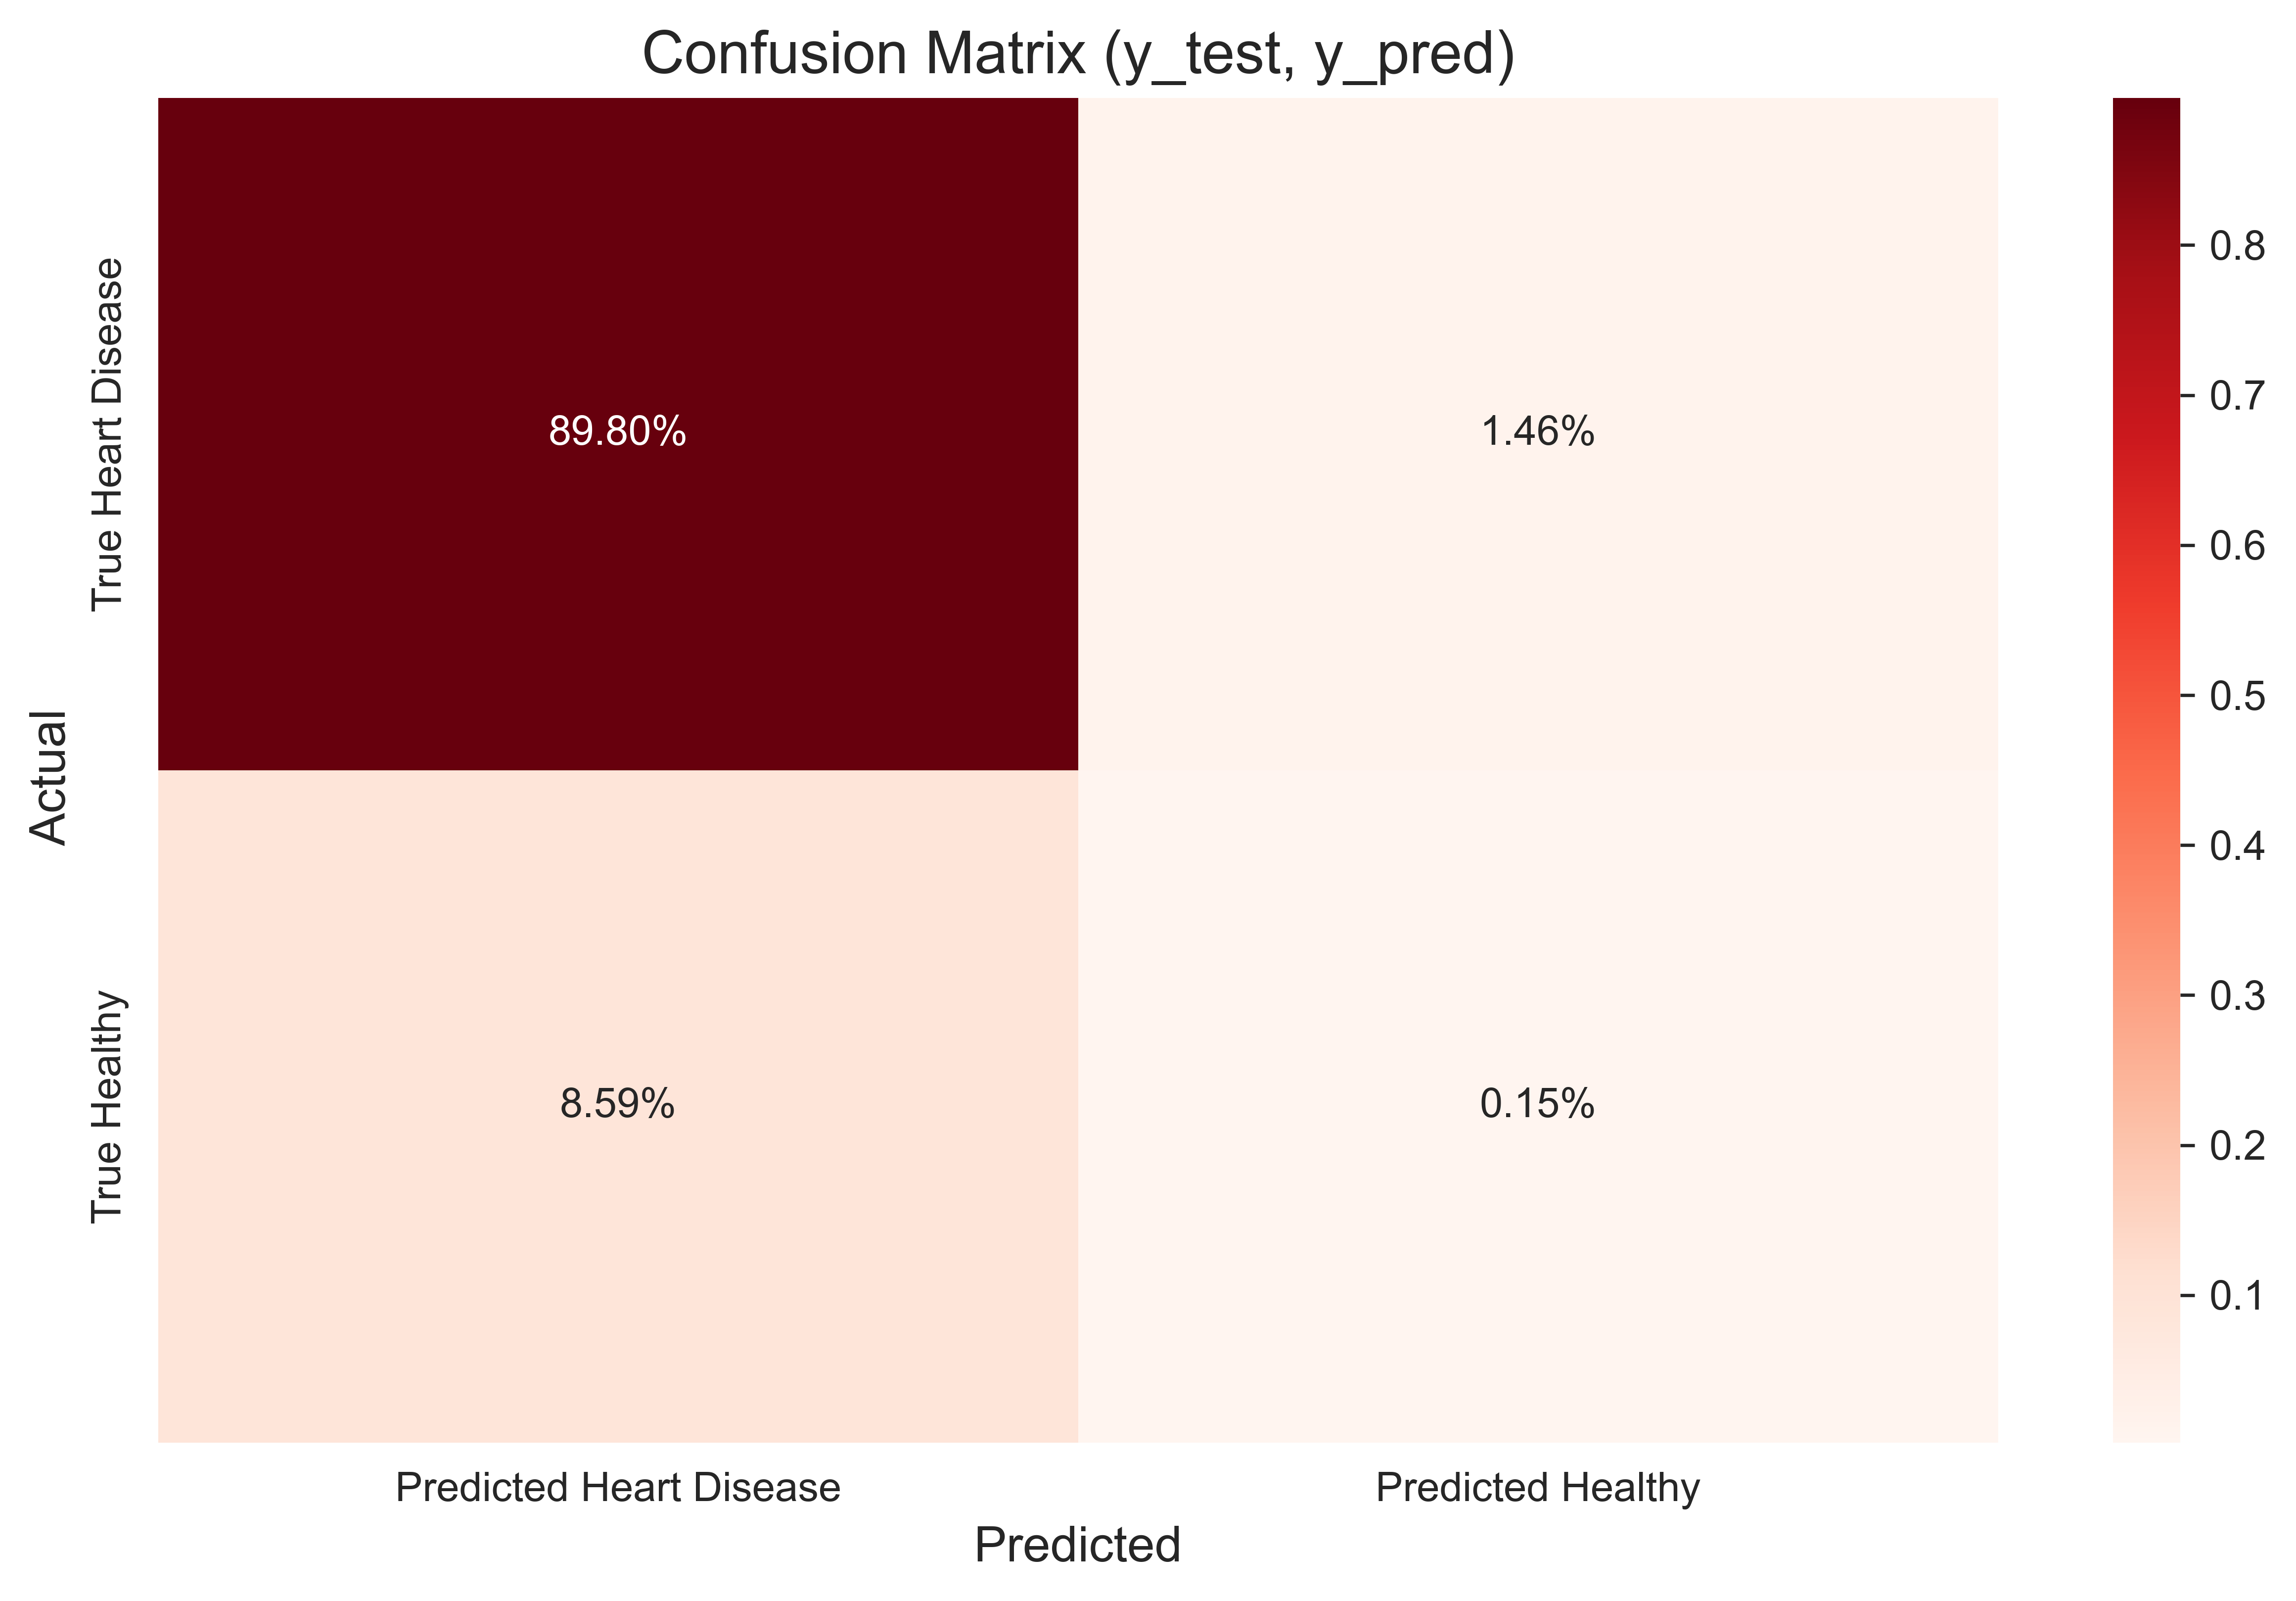

In [110]:
# confusion matrix on y_test/predict
y_pred = y_pred_log_reg_gridcv
cm = confusion_matrix(y_test, y_pred)

f, ax = plt.subplots(figsize=(10, 6))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['Predicted Heart Disease','Predicted Healthy'])            #double check x y labels
ax.yaxis.set_ticklabels(['True Heart Disease','True Healthy'])

plt.title('Confusion Matrix (y_test, y_pred)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

plt.savefig("confusion-matrix.jpeg");


In [111]:
# classification report on y_test/predict
print(classification_report(y_test, 
                            y_pred, 
                            target_names=['no heart disease', 'yes heart disease']))



                   precision    recall  f1-score   support

 no heart disease       0.91      0.98      0.95     58367
yes heart disease       0.10      0.02      0.03      5592

         accuracy                           0.90     63959
        macro avg       0.50      0.50      0.49     63959
     weighted avg       0.84      0.90      0.87     63959



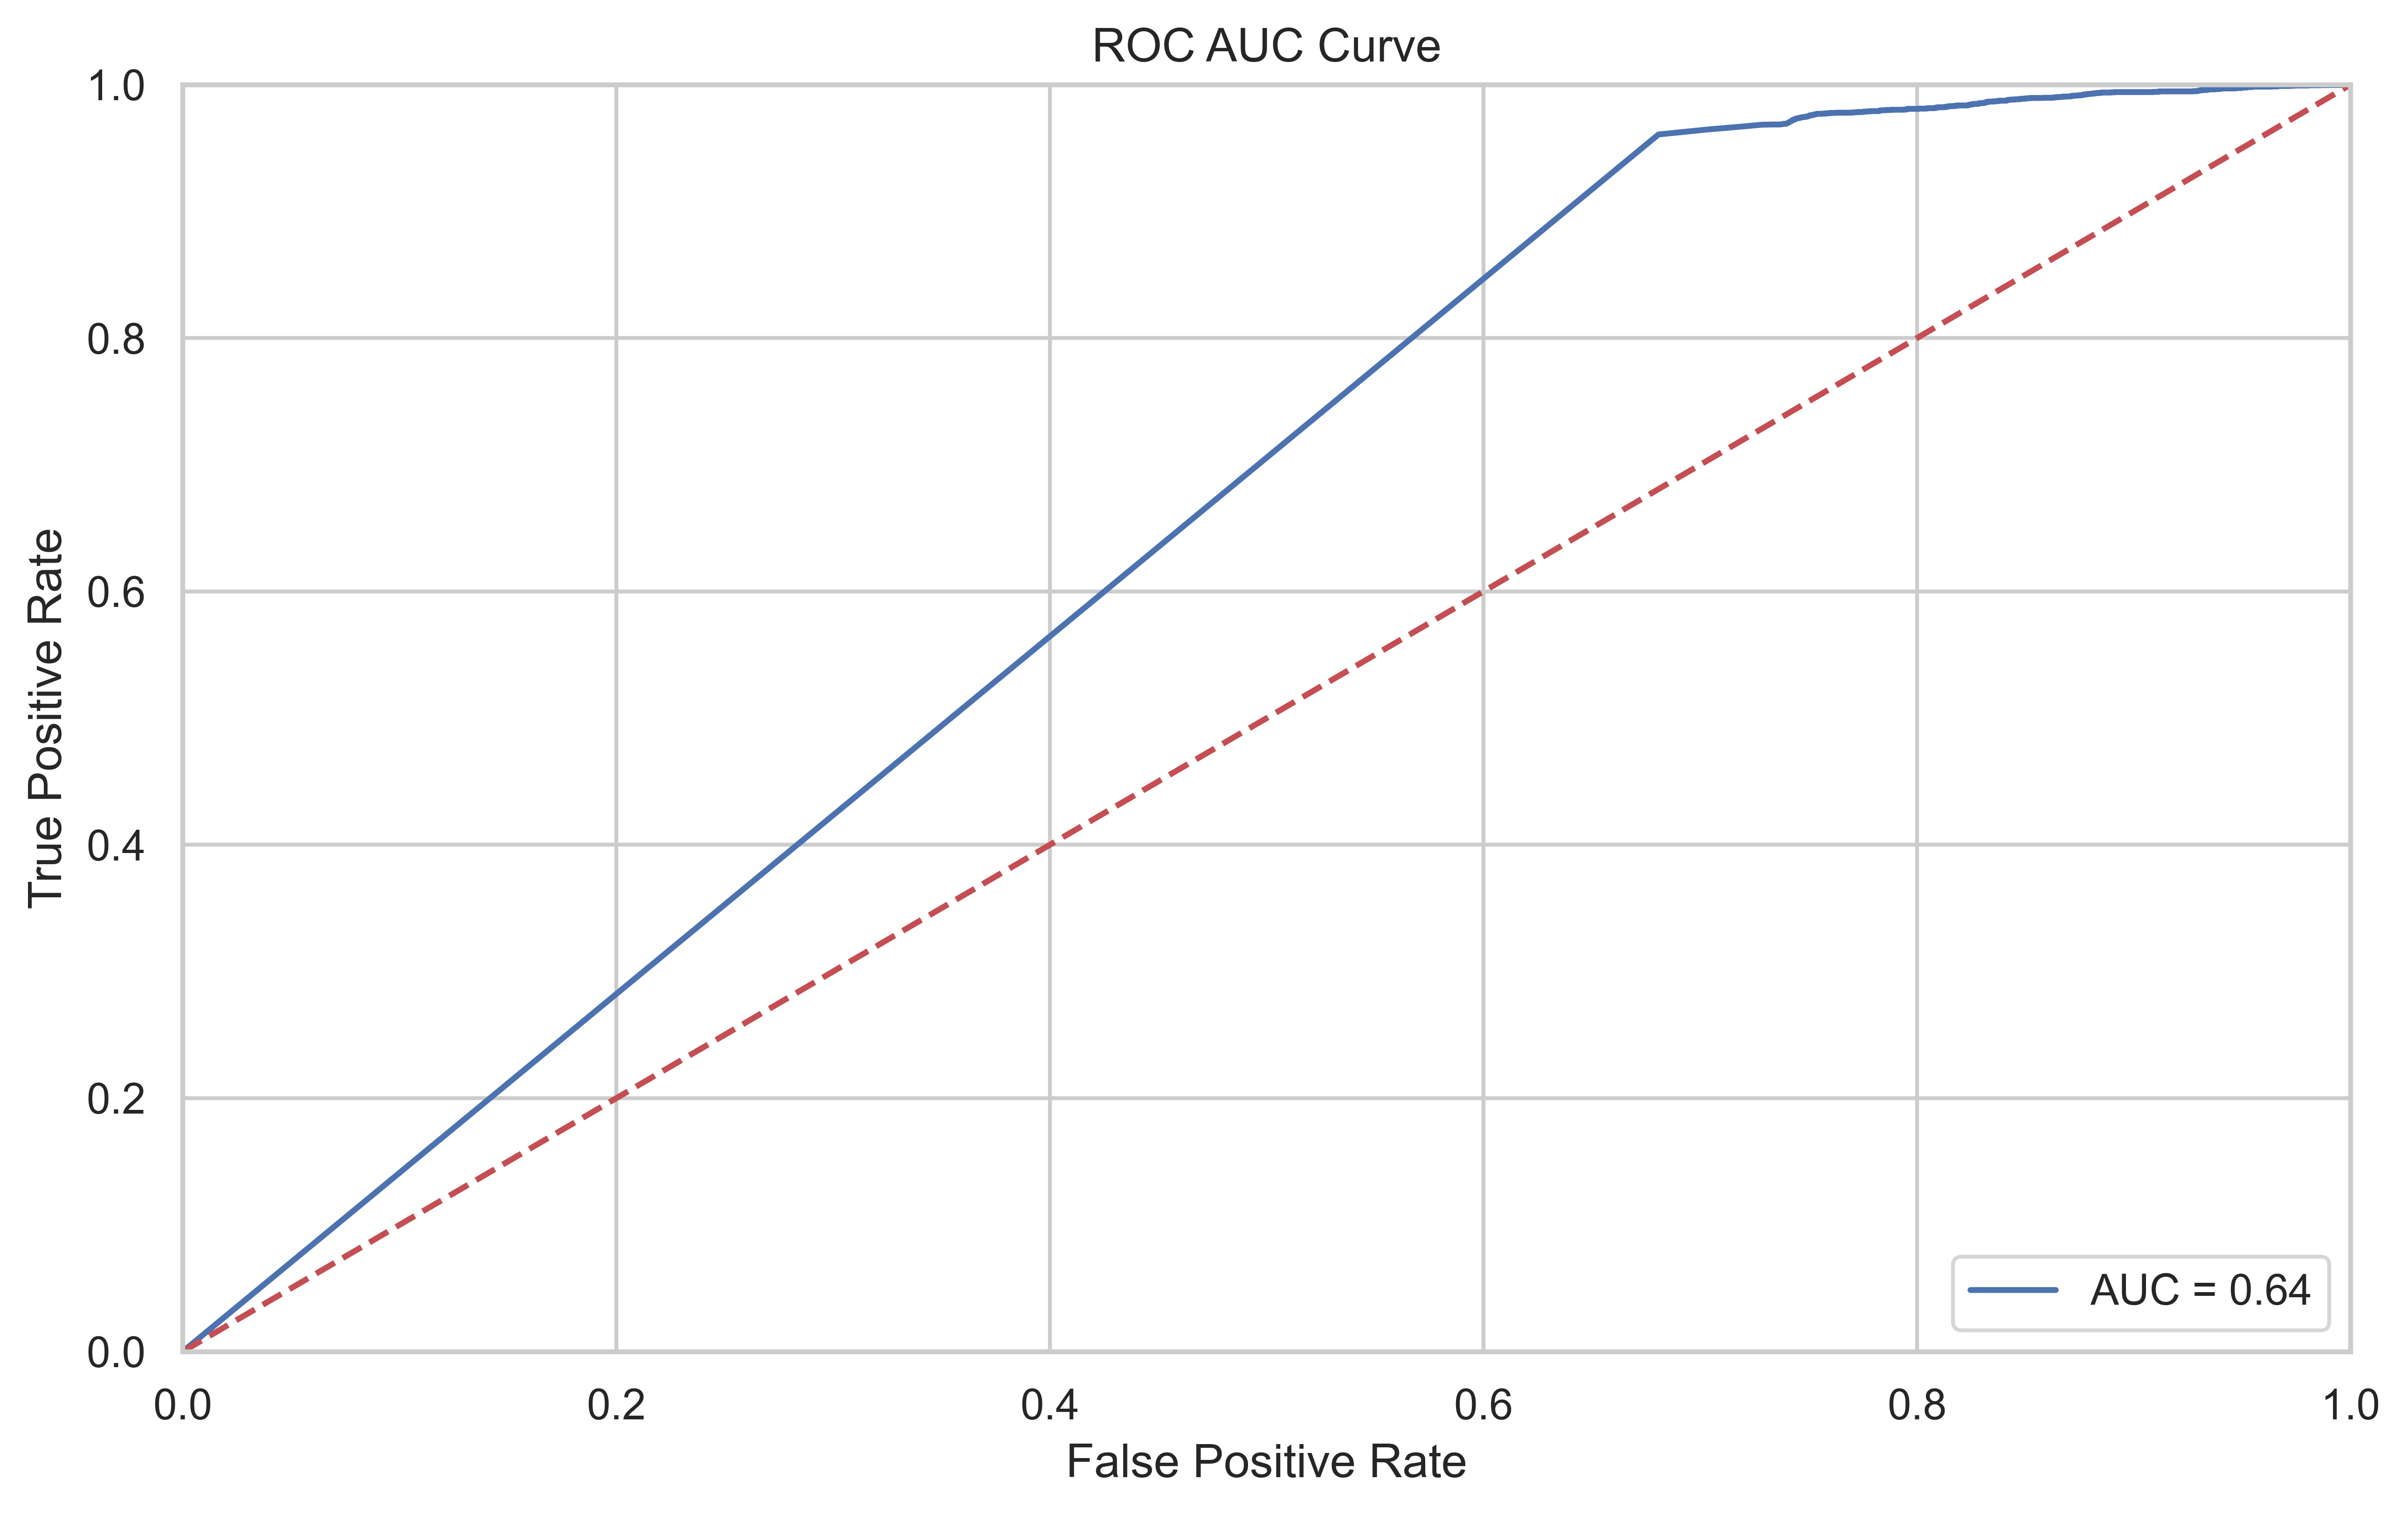

In [112]:
# ROC AUC curve on y_test/predict
probs = log_reg_gridcv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 6))

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC AUC Curve')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("roc-auc-curve.jpeg");

In [113]:
# feature importance log_reg_gridcv
imp_feat = pd.DataFrame()
feat = list(X)
imp = log_reg_gridcv.coef_[0]
imp_feat['Feature'] = feat
imp_feat['Importance'] = imp
imp_feat.sort_values(by=['Importance'], ascending=False, inplace=True)


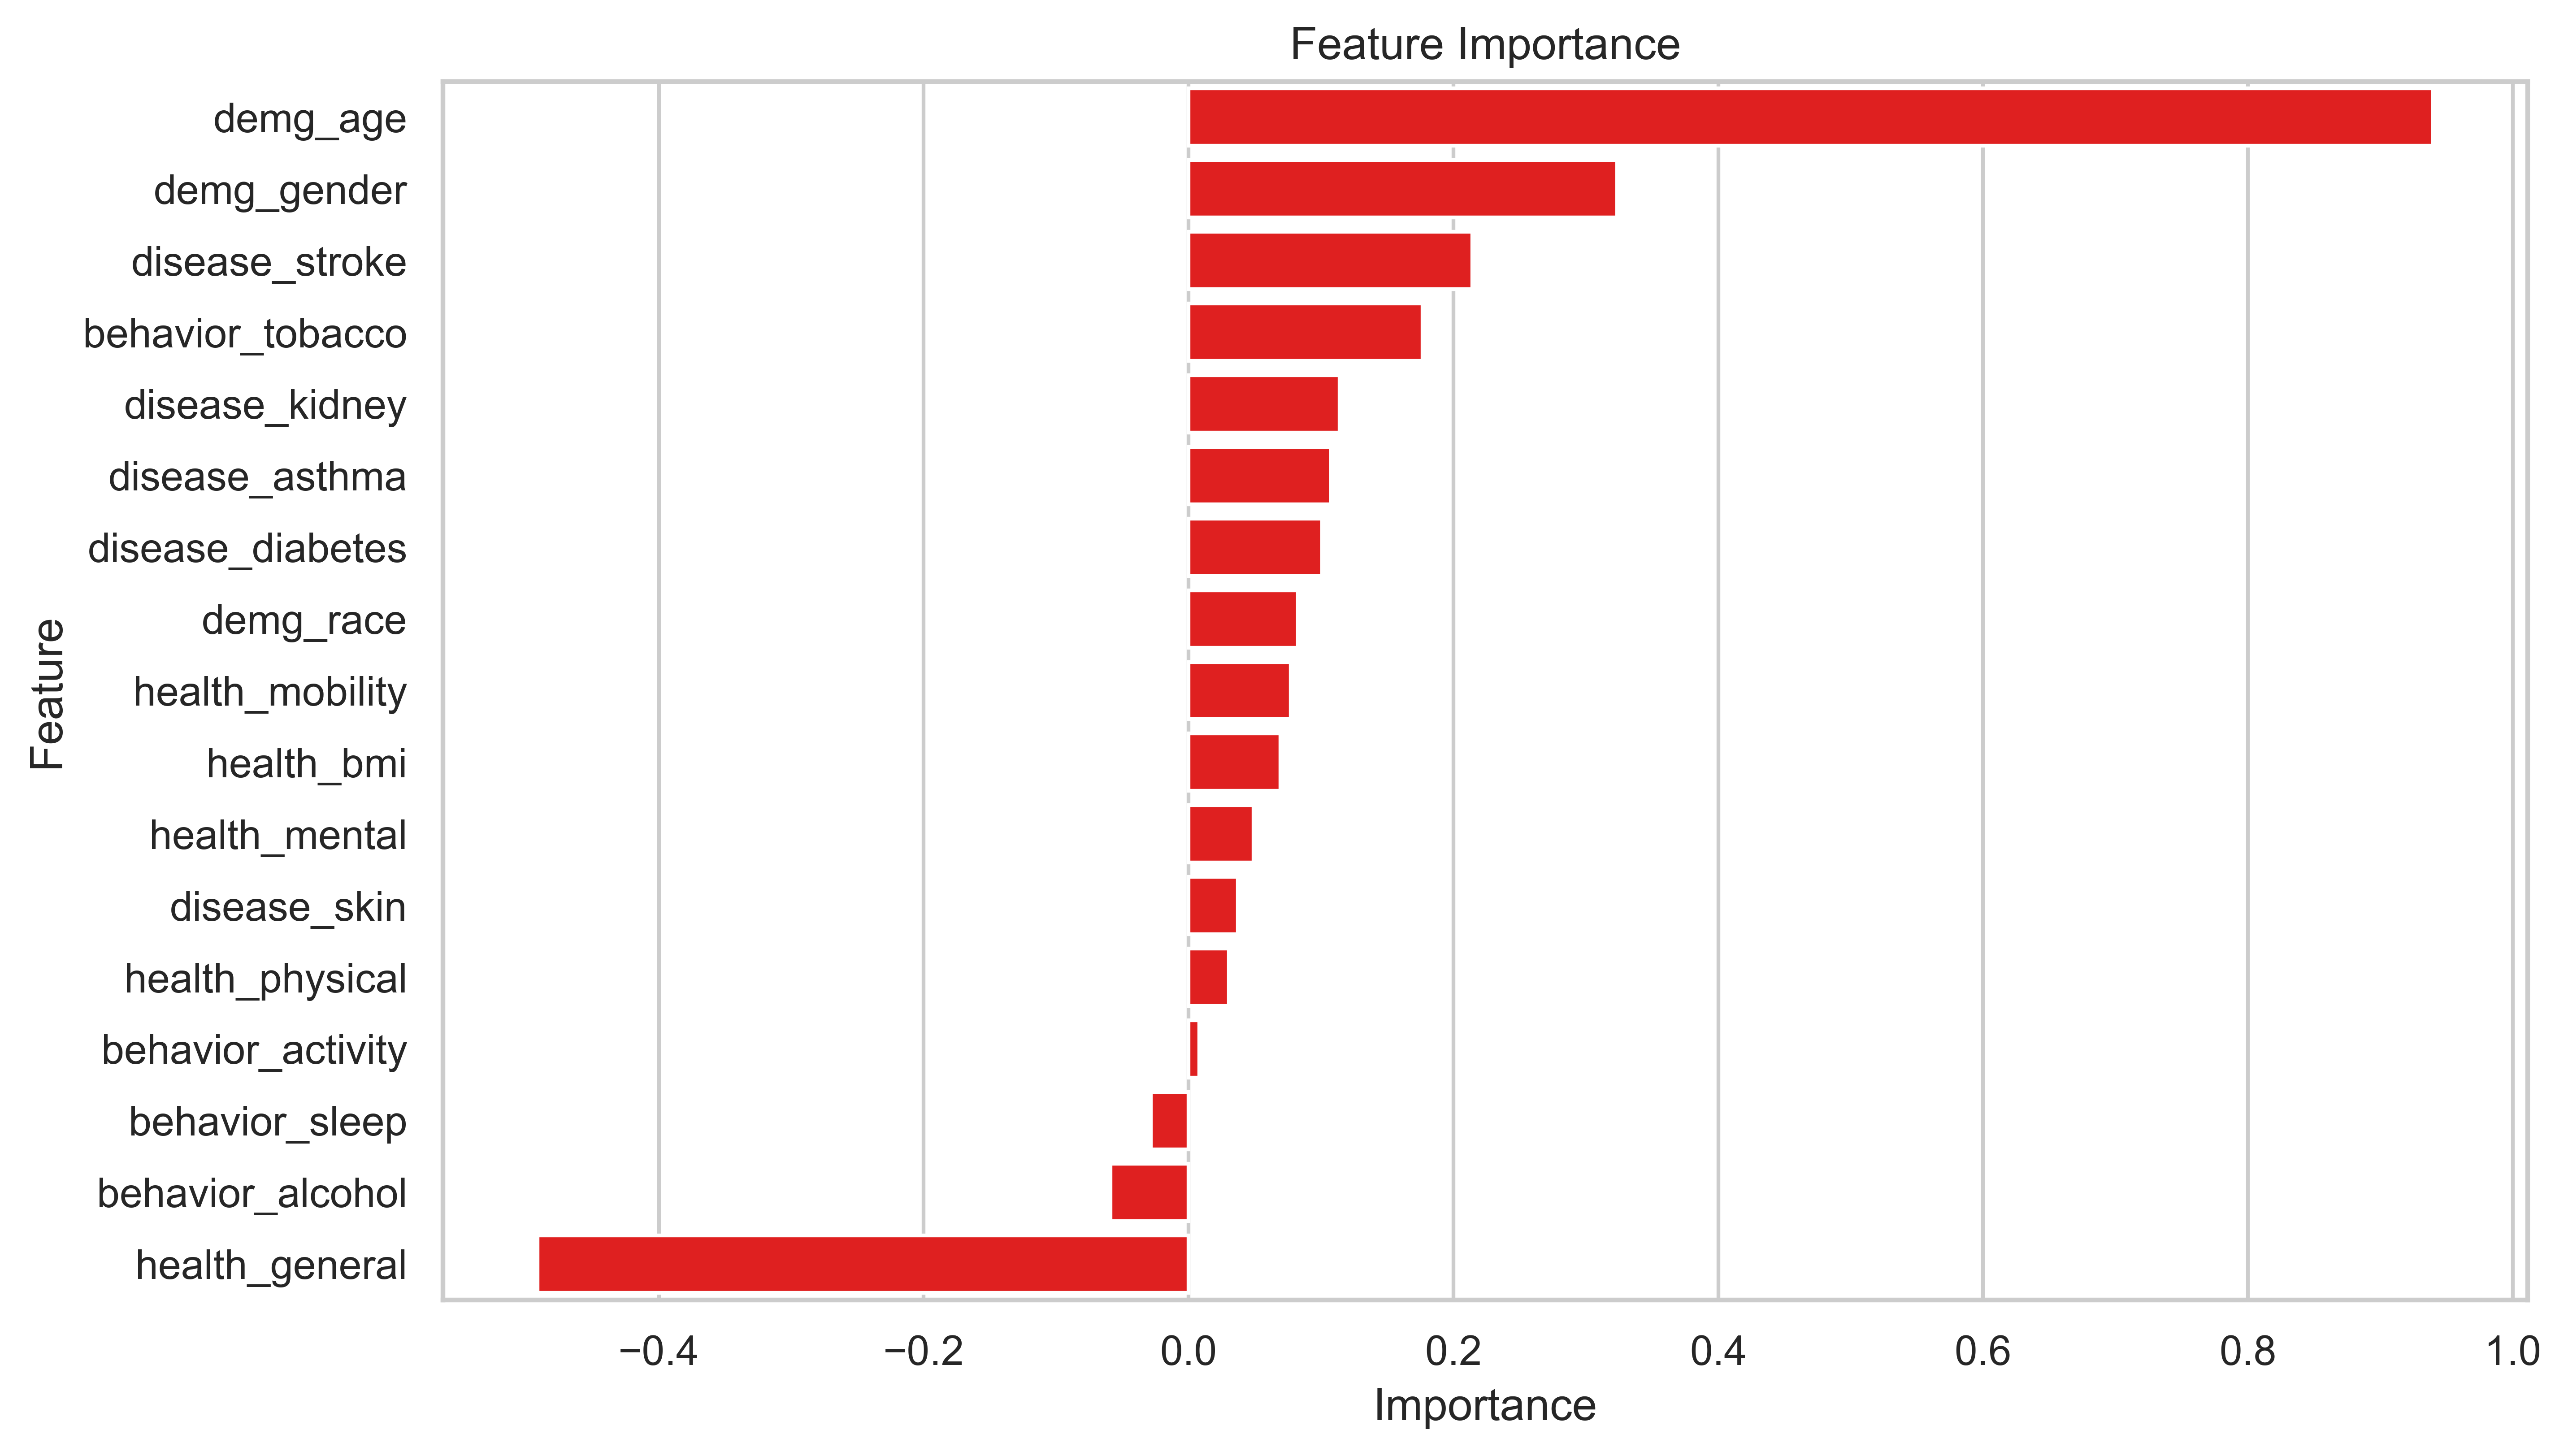

In [114]:
# vizualize feature importance
f, ax = plt.subplots(figsize=(10, 6))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

sns.barplot(x='Importance', y='Feature', data=imp_feat, color='red');
plt.title('Feature Importance')

plt.savefig("feature-importance.jpeg");


### 7.2 Interpret<a id='72'></a> 

In [ ]:
# persona 1: couch potato, drinks every day, high BMI, has diabetes

In [ ]:
# persona 2: runner, drinks every day, normal BMI, bordrline diabetes

In [ ]:
# persona 3: walks to works, social drinker, normal BMI, no diabetes

[back to top](#top)